In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr
from dask.diagnostics import ProgressBar

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import cartopy.crs as ccrs

from weatherbench2.visualization import set_wb2_style
from weatherbench2.metrics import _spatial_average

# Ground Truth ERA5

In [ ]:
era5_pc0 = xr.open_dataset('results/era5_pc0.nc').load()

In [3]:
era5_pc0_spatial_avg = era5_pc0.map(_spatial_average, region=None, skipna=False)

## GraphCast

These jobs can be run on GCP as long as a project, bucket and region are specified

In [ ]:
python pc/compute_pc.py \
--prediction_path=gs://weatherbench2/datasets/graphcast/2020/date_range_2019-11-16_2021-02-01_12_hours-240x121_equiangular_with_poles_conservative.zarr \
--target_path=gs://weatherbench2/datasets/era5/1959-2023_01_10-6h-240x121_equiangular_with_poles_conservative.zarr \
--output_path=gs://$BUCKET/easyuq/pc/graphcast_240x121_vs_era5.zarr \
--variables=2m_temperature,mean_sea_level_pressure,10m_wind_speed,total_precipitation_24hr \
--time_start=2020-01-01 \
--time_stop=2020-12-31 \
--skip_non_headline=True \
--chunk_size_lon=8 \
--chunk_size_lat=11 \
--runner=DataflowRunner \
-- \
--project=$PROJECT \
--region=$REGION \
--job_name=compute-pc-graphcast-240x121 \
--temp_location=gs://$BUCKET/tmp/ \
--staging_location=gs://$BUCKET/staging/ \
--setup_file=./setup.py \
--worker_machine_type=c3-standard-8 \
--autoscaling_algorithm=THROUGHPUT_BASED

In [8]:
# Load PC results from the GCP bucket into memory
with ProgressBar():
    graphcast_vs_era5_pc = xr.open_zarr('gs://$BUCKET/easyuq/pc/graphcast_240x121_vs_era5.zarr').load()

[########################################] | 100% Completed | 57.89 s


In [34]:
# Compute PCS
graphcast_vs_era5_pcs = ((era5_pc0 - graphcast_vs_era5_pc.sel(metric='pc')) / era5_pc0).expand_dims({"metric": ["pcs"]})
# Concatenate to other metrics
graphcast_vs_era5_results = xr.concat([graphcast_vs_era5_pc, graphcast_vs_era5_pcs], dim="metric")
# Write to disk as NetCDF file
graphcast_vs_era5_results.to_netcdf('results/graphcast_vs_era5.nc', engine='h5netcdf')

In [9]:
graphcast_vs_era5_results_spatial_avg = graphcast_vs_era5_results.sel(metric=['pc', 'pcs']).map(_spatial_average, region=None, skipna=False)

## Pangu-Weather

In [ ]:
python pc/compute_pc.py \
--prediction_path=gs://weatherbench2/datasets/pangu/2018-2022_0012_240x121_equiangular_with_poles_conservative.zarr \
--target_path=gs://weatherbench2/datasets/era5/1959-2023_01_10-6h-240x121_equiangular_with_poles_conservative.zarr \
--output_path=gs://$BUCKET/easyuq/pc/pangu_240x121_vs_era5.zarr \
--variables=2m_temperature,mean_sea_level_pressure,10m_wind_speed \
--time_start=2020-01-01 \
--time_stop=2020-12-31 \
--skip_non_headline=True \
--chunk_size_lon=8 \
--chunk_size_lat=11 \
--runner=DataflowRunner \
-- \
--project=$PROJECT \
--region=$REGION \
--job_name=compute-pc-pangu-240x121 \
--temp_location=gs://$BUCKET/tmp/ \
--staging_location=gs://$BUCKET/staging/ \
--setup_file=./setup.py \
--worker_machine_type=c3-standard-8 \
--autoscaling_algorithm=THROUGHPUT_BASED

In [23]:
with ProgressBar():
    pangu_vs_era5_pc = xr.open_zarr('gs://$BUCKET/easyuq/pc/pangu_240x121_vs_era5.zarr').load()

[########################################] | 100% Completed | 50.03 s


In [35]:
pangu_vs_era5_pcs = ((era5_pc0 - pangu_vs_era5_pc.sel(metric='pc')) / era5_pc0).expand_dims({"metric": ["pcs"]})
pangu_vs_era5_results = xr.concat([pangu_vs_era5_pc, pangu_vs_era5_pcs], dim="metric")
pangu_vs_era5_results.to_netcdf('results/pangu_vs_era5.nc', engine='h5netcdf')

In [11]:
pangu_vs_era5_results_spatial_avg = pangu_vs_era5_results.sel(metric=['pc', 'pcs']).map(_spatial_average, region=None, skipna=False)

## IFS HRES

In [ ]:
python pc/compute_pc.py \
--prediction_path=gs://weatherbench2/datasets/hres/2016-2022-0012-240x121_equiangular_with_poles_conservative.zarr \
--target_path=gs://weatherbench2/datasets/era5/1959-2023_01_10-6h-240x121_equiangular_with_poles_conservative.zarr \
--output_path=gs://$BUCKET/easyuq/pc/ifs_hres_240x121_vs_era5.zarr \
--variables=2m_temperature,mean_sea_level_pressure,10m_wind_speed,total_precipitation_24hr \
--time_start=2020-01-01 \
--time_stop=2020-12-31 \
--skip_non_headline=True \
--chunk_size_lon=8 \
--chunk_size_lat=11 \
--runner=DataflowRunner \
-- \
--project=$PROJECT \
--region=$REGION \
--job_name=compute-pc-ifs-hres-240x121 \
--temp_location=gs://$BUCKET/tmp/ \
--staging_location=gs://$BUCKET/staging/ \
--setup_file=./setup.py \
--worker_machine_type=c3-standard-8 \
--autoscaling_algorithm=THROUGHPUT_BASED

In [25]:
with ProgressBar():
    ifs_hres_vs_era5_pc = xr.open_zarr('gs://$BUCKET/easyuq/pc/ifs_hres_240x121_vs_era5.zarr').load()

[########################################] | 100% Completed | 60.13 s


In [36]:
ifs_hres_vs_era5_pcs = ((era5_pc0 - ifs_hres_vs_era5_pc.sel(metric='pc')) / era5_pc0).expand_dims({"metric": ["pcs"]})
ifs_hres_vs_era5_results = xr.concat([ifs_hres_vs_era5_pc, ifs_hres_vs_era5_pcs], dim="metric")
ifs_hres_vs_era5_results.to_netcdf('results/ifs_hres_vs_era5.nc', engine='h5netcdf')

In [13]:
ifs_hres_vs_era5_results_spatial_avg = ifs_hres_vs_era5_results.sel(metric=['pc', 'pcs']).map(_spatial_average, region=None, skipna=False)

# Ground Truth IFS Analysis

In [14]:
ifs_analysis_pc0 = xr.open_dataset('results/ifs_analysis_pc0.nc').load()

In [15]:
ifs_analysis_pc0_spatial_avg = ifs_analysis_pc0.map(_spatial_average, region=None, skipna=False)

## GraphCast

In [ ]:
python pc/compute_pc.py \
--prediction_path=gs://weatherbench2/datasets/graphcast/2020/date_range_2019-11-16_2021-02-01_12_hours-240x121_equiangular_with_poles_conservative.zarr \
--target_path=gs://weatherbench2/datasets/hres_t0/2016-2022-6h-240x121_equiangular_with_poles_conservative.zarr \
--output_path=gs://$BUCKET/easyuq/pc/graphcast_240x121_vs_ifs_analysis.zarr \
--variables=2m_temperature,mean_sea_level_pressure,10m_wind_speed \
--time_start=2020-01-01 \
--time_stop=2020-12-31 \
--skip_non_headline=True \
--chunk_size_lon=8 \
--chunk_size_lat=11 \
--runner=DataflowRunner \
-- \
--project=$PROJECT \
--region=$REGION \
--job_name=compute-pc-graphcast-240x121-vs-analysis \
--temp_location=gs://$BUCKET/tmp/ \
--staging_location=gs://$BUCKET/staging/ \
--setup_file=./setup.py \
--worker_machine_type=c3-standard-8 \
--autoscaling_algorithm=THROUGHPUT_BASED

In [38]:
with ProgressBar():
    graphcast_vs_ifs_analysis_pc = xr.open_zarr('gs://$BUCKET/easyuq/pc/graphcast_240x121_vs_ifs_analysis.zarr').load()

[########################################] | 100% Completed | 50.18 s


In [41]:
graphcast_vs_ifs_analysis_pcs = ((ifs_analysis_pc0 - graphcast_vs_ifs_analysis_pc.sel(metric='pc')) / ifs_analysis_pc0).expand_dims({"metric": ["pcs"]})
graphcast_vs_ifs_analysis_results = xr.concat([graphcast_vs_ifs_analysis_pc, graphcast_vs_ifs_analysis_pcs], dim="metric")
graphcast_vs_ifs_analysis_results.to_netcdf('results/graphcast_vs_ifs_analysis.nc', engine='h5netcdf')

In [17]:
graphcast_vs_ifs_analysis_results_spatial_avg = graphcast_vs_ifs_analysis_results.sel(metric=['pc', 'pcs']).map(_spatial_average, region=None, skipna=False)

## Pangu-Weather

In [ ]:
python pc/compute_pc.py \
--prediction_path=gs://weatherbench2/datasets/pangu/2018-2022_0012_240x121_equiangular_with_poles_conservative.zarr \
--target_path=gs://weatherbench2/datasets/hres_t0/2016-2022-6h-240x121_equiangular_with_poles_conservative.zarr \
--output_path=gs://$BUCKET/easyuq/pc/pangu_240x121_vs_ifs_analysis.zarr \
--variables=2m_temperature,mean_sea_level_pressure,10m_wind_speed \
--time_start=2020-01-01 \
--time_stop=2020-12-31 \
--skip_non_headline=True \
--chunk_size_lon=8 \
--chunk_size_lat=11 \
--runner=DataflowRunner \
-- \
--project=$PROJECT \
--region=$REGION \
--job_name=compute-pc-pangu-240x121-vs-analysis  \
--temp_location=gs://$BUCKET/tmp/ \
--staging_location=gs://$BUCKET/staging/ \
--setup_file=./setup.py \
--worker_machine_type=c3-standard-8 \
--autoscaling_algorithm=THROUGHPUT_BASED

In [42]:
with ProgressBar():
    pangu_vs_ifs_analysis_pc = xr.open_zarr('gs://$BUCKET/easyuq/pc/pangu_240x121_vs_ifs_analysis.zarr').load()

[########################################] | 100% Completed | 46.31 s


In [43]:
pangu_vs_ifs_analysis_pcs = ((ifs_analysis_pc0 - pangu_vs_ifs_analysis_pc.sel(metric='pc')) / ifs_analysis_pc0).expand_dims({"metric": ["pcs"]})
pangu_vs_ifs_analysis_results = xr.concat([pangu_vs_ifs_analysis_pc, pangu_vs_ifs_analysis_pcs], dim="metric")
pangu_vs_ifs_analysis_results.to_netcdf('results/pangu_vs_ifs_analysis.nc', engine='h5netcdf')

In [19]:
pangu_vs_ifs_analysis_results_spatial_avg = pangu_vs_ifs_analysis_results.sel(metric=['pc', 'pcs']).map(_spatial_average, region=None, skipna=False)

## IFS HRES

In [ ]:
python pc/compute_pc.py \
--prediction_path=gs://weatherbench2/datasets/hres/2016-2022-0012-240x121_equiangular_with_poles_conservative.zarr \
--target_path=gs://weatherbench2/datasets/hres_t0/2016-2022-6h-240x121_equiangular_with_poles_conservative.zarr \
--output_path=gs://$BUCKET/easyuq/pc/ifs_hres_240x121_vs_ifs_analysis.zarr \
--variables=2m_temperature,mean_sea_level_pressure,10m_wind_speed \
--time_start=2020-01-01 \
--time_stop=2020-12-31 \
--skip_non_headline=True \
--chunk_size_lon=8 \
--chunk_size_lat=11 \
--runner=DataflowRunner \
-- \
--project=$PROJECT \
--region=$REGION \
--job_name=compute-pc-ifs-hres-240x121-vs-analysis \
--temp_location=gs://$BUCKET/tmp/ \
--staging_location=gs://$BUCKET/staging/ \
--setup_file=./setup.py \
--worker_machine_type=c3-standard-8 \
--autoscaling_algorithm=THROUGHPUT_BASED

In [44]:
with ProgressBar():
    ifs_hres_vs_ifs_analysis_pc = xr.open_zarr('gs://$BUCKET/easyuq/pc/ifs_hres_240x121_vs_ifs_analysis.zarr').load()

[########################################] | 100% Completed | 37.64 s


In [45]:
ifs_hres_vs_ifs_analysis_pcs = ((ifs_analysis_pc0 - ifs_hres_vs_ifs_analysis_pc.sel(metric='pc')) / ifs_analysis_pc0).expand_dims({"metric": ["pcs"]})
ifs_hres_vs_ifs_analysis_results = xr.concat([ifs_hres_vs_ifs_analysis_pc, ifs_hres_vs_ifs_analysis_pcs], dim="metric")
ifs_hres_vs_ifs_analysis_results.to_netcdf('results/ifs_hres_vs_ifs_analysis.nc', engine='h5netcdf')

In [21]:
ifs_hres_vs_ifs_analysis_results_spatial_avg = ifs_hres_vs_ifs_analysis_results.sel(metric=['pc', 'pcs']).map(_spatial_average, region=None, skipna=False)

# Plots

In [93]:
# Apply the WeatherBench2 plotting style
set_wb2_style()

In [28]:
# Ensure LaTeX‐style fonts for all text in the plots
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

In [22]:
# Define variables, variable abbreviations and units
variables = ['mean_sea_level_pressure', '2m_temperature', '10m_wind_speed', 'total_precipitation_24hr']
titles = ['MSLP', 'T2M', 'WS10', 'TP24hr']
units = [r'$\left[ \text{Pa} \right]$', r'$ \left[ \text{K} \right]$', r'$ \left[ \text{m}/\text{s}^{-1} \right] $', r'$\left[ \text{m}/\text{d}^{-1} \right]$']

In [23]:
# Lead times as numpy timedeltas for slicing
lead_times = [
    np.timedelta64(1, 'D'),
    np.timedelta64(3, 'D'),
    np.timedelta64(5, 'D'),
    np.timedelta64(7, 'D'),
    np.timedelta64(10, 'D')
]
# Convert timedeltas into integer days for plotting
lead_time_days = lead_times/np.timedelta64(1, 'D')

Line plot for PC of WeatherBench 2 models with ERA5 (top) and IFS analysis (bottom) as ground truth, latitude weighted mean.

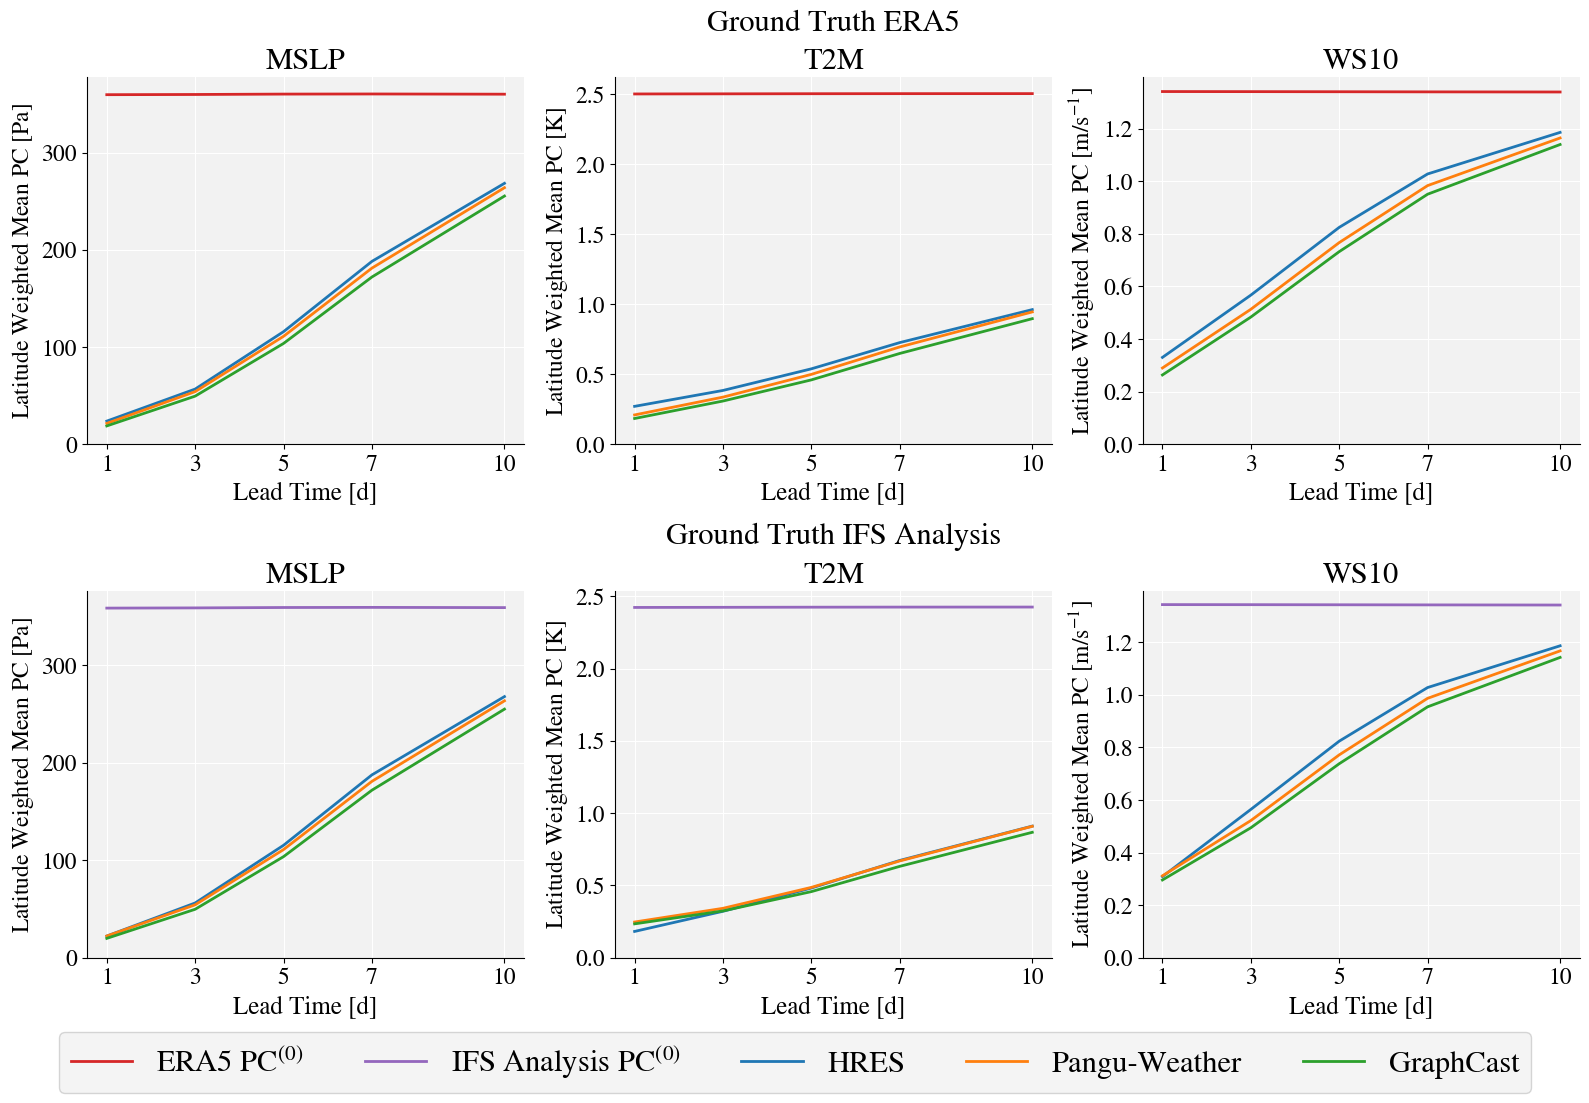

In [42]:
# Create the figure and subplots
fig, axes = plt.subplots(2, len(variables[:-1]), figsize=(16, 10))

# ----------------------- Ground Truth Era5 -----------------------
for ax, var, title, unit in zip(axes[0, :], variables[:-1], titles[:-1], units[:-1]):
    ax.plot(lead_time_days,
            era5_pc0_spatial_avg.sel(prediction_timedelta=lead_times)[var],
            label='ERA5 $\\text{PC}^{(0)}$', color='tab:red')
    ax.plot(lead_time_days,
            ifs_hres_vs_era5_results_spatial_avg.sel(metric='pc')[var], color='tab:blue')
    ax.plot(lead_time_days,
            pangu_vs_era5_results_spatial_avg.sel(metric='pc')[var], color='tab:orange')
    ax.plot(lead_time_days,
            graphcast_vs_era5_results_spatial_avg.sel(metric='pc', prediction_timedelta=lead_times)[var], color='tab:green')

    ax.set_xlabel('Lead Time [d]', fontsize=18)
    ax.set_title(title, fontsize=22)
    ax.set_xticks(lead_time_days)
    ax.set_ylim(0)
    ax.set_ylabel('Latitude Weighted Mean PC ' + unit, fontsize=17)
    ax.tick_params(axis='both', which='major', labelsize=17)

# ----------------------- Ground Truth IFS Analysis -----------------------
for ax, var, title, unit in zip(axes[1, :], variables[:-1], titles[:-1], units[:-1]):
    ax.plot(lead_time_days,
            ifs_analysis_pc0_spatial_avg.sel(prediction_timedelta=lead_times)[var],
            label='IFS Analysis $\\text{PC}^{(0)}$', color='tab:purple')
    ax.plot(lead_time_days,
            ifs_hres_vs_ifs_analysis_results_spatial_avg.sel(metric='pc')[var],
            label='HRES', color='tab:blue')
    ax.plot(lead_time_days,
            pangu_vs_ifs_analysis_results_spatial_avg.sel(metric='pc')[var],
            label='Pangu-Weather', color='tab:orange')
    ax.plot(lead_time_days,
            graphcast_vs_ifs_analysis_results_spatial_avg.sel(metric='pc', prediction_timedelta=lead_times)[var],
            label='GraphCast', color='tab:green')

    ax.set_xlabel('Lead Time [d]', fontsize=18)
    ax.set_title(title, fontsize=22)
    ax.set_xticks(lead_time_days)
    ax.set_ylim(0)
    ax.set_ylabel('Latitude Weighted Mean PC ' + unit, fontsize=17)
    ax.tick_params(axis='both', which='major', labelsize=17)

plt.tight_layout()
plt.subplots_adjust(hspace=0.4)

# ----------------------- Row Titles -----------------------
# Upper row:
row1_left = axes[0, 0].get_position().x0
row1_right = axes[0, -1].get_position().x1
row1_top = axes[0, 0].get_position().y1
row1_center_x = (row1_left + row1_right) / 2

# Lower row:
row2_left = axes[1, 0].get_position().x0
row2_right = axes[1, -1].get_position().x1
row2_top = axes[1, 0].get_position().y1
row2_center_x = (row2_left + row2_right) / 2

# Place the row titles at some vertical offset above each row
fig.text(row1_center_x, row1_top + 0.04, "Ground Truth ERA5", 
         ha='center', va='bottom', fontsize=22)
fig.text(row2_center_x, row2_top + 0.04, "Ground Truth IFS Analysis", 
         ha='center', va='bottom', fontsize=22)

# ----------------------- Combined Legend --------------------------
handles_upper, labels_upper = axes[0, 0].get_legend_handles_labels()
handles_lower, labels_lower = axes[1, 0].get_legend_handles_labels()

# Combine them into a dictionary to eliminate duplicates
combined_legend = {}
for h, l in zip(handles_upper, labels_upper):
    combined_legend[l] = h
for h, l in zip(handles_lower, labels_lower):
    combined_legend[l] = h

combined_handles = list(combined_legend.values())
combined_labels = list(combined_legend.keys())

fig.legend(combined_handles, combined_labels, loc='lower center', ncol=5, 
           bbox_to_anchor=(0.5, -0.075), fontsize=22)

plt.savefig('plots/lineplot_lat_mean_pc_without_precip.png', facecolor='white', edgecolor='none', bbox_inches='tight')
plt.show()

Map plot for PCS of GraphCast with ERA5 as ground truth.

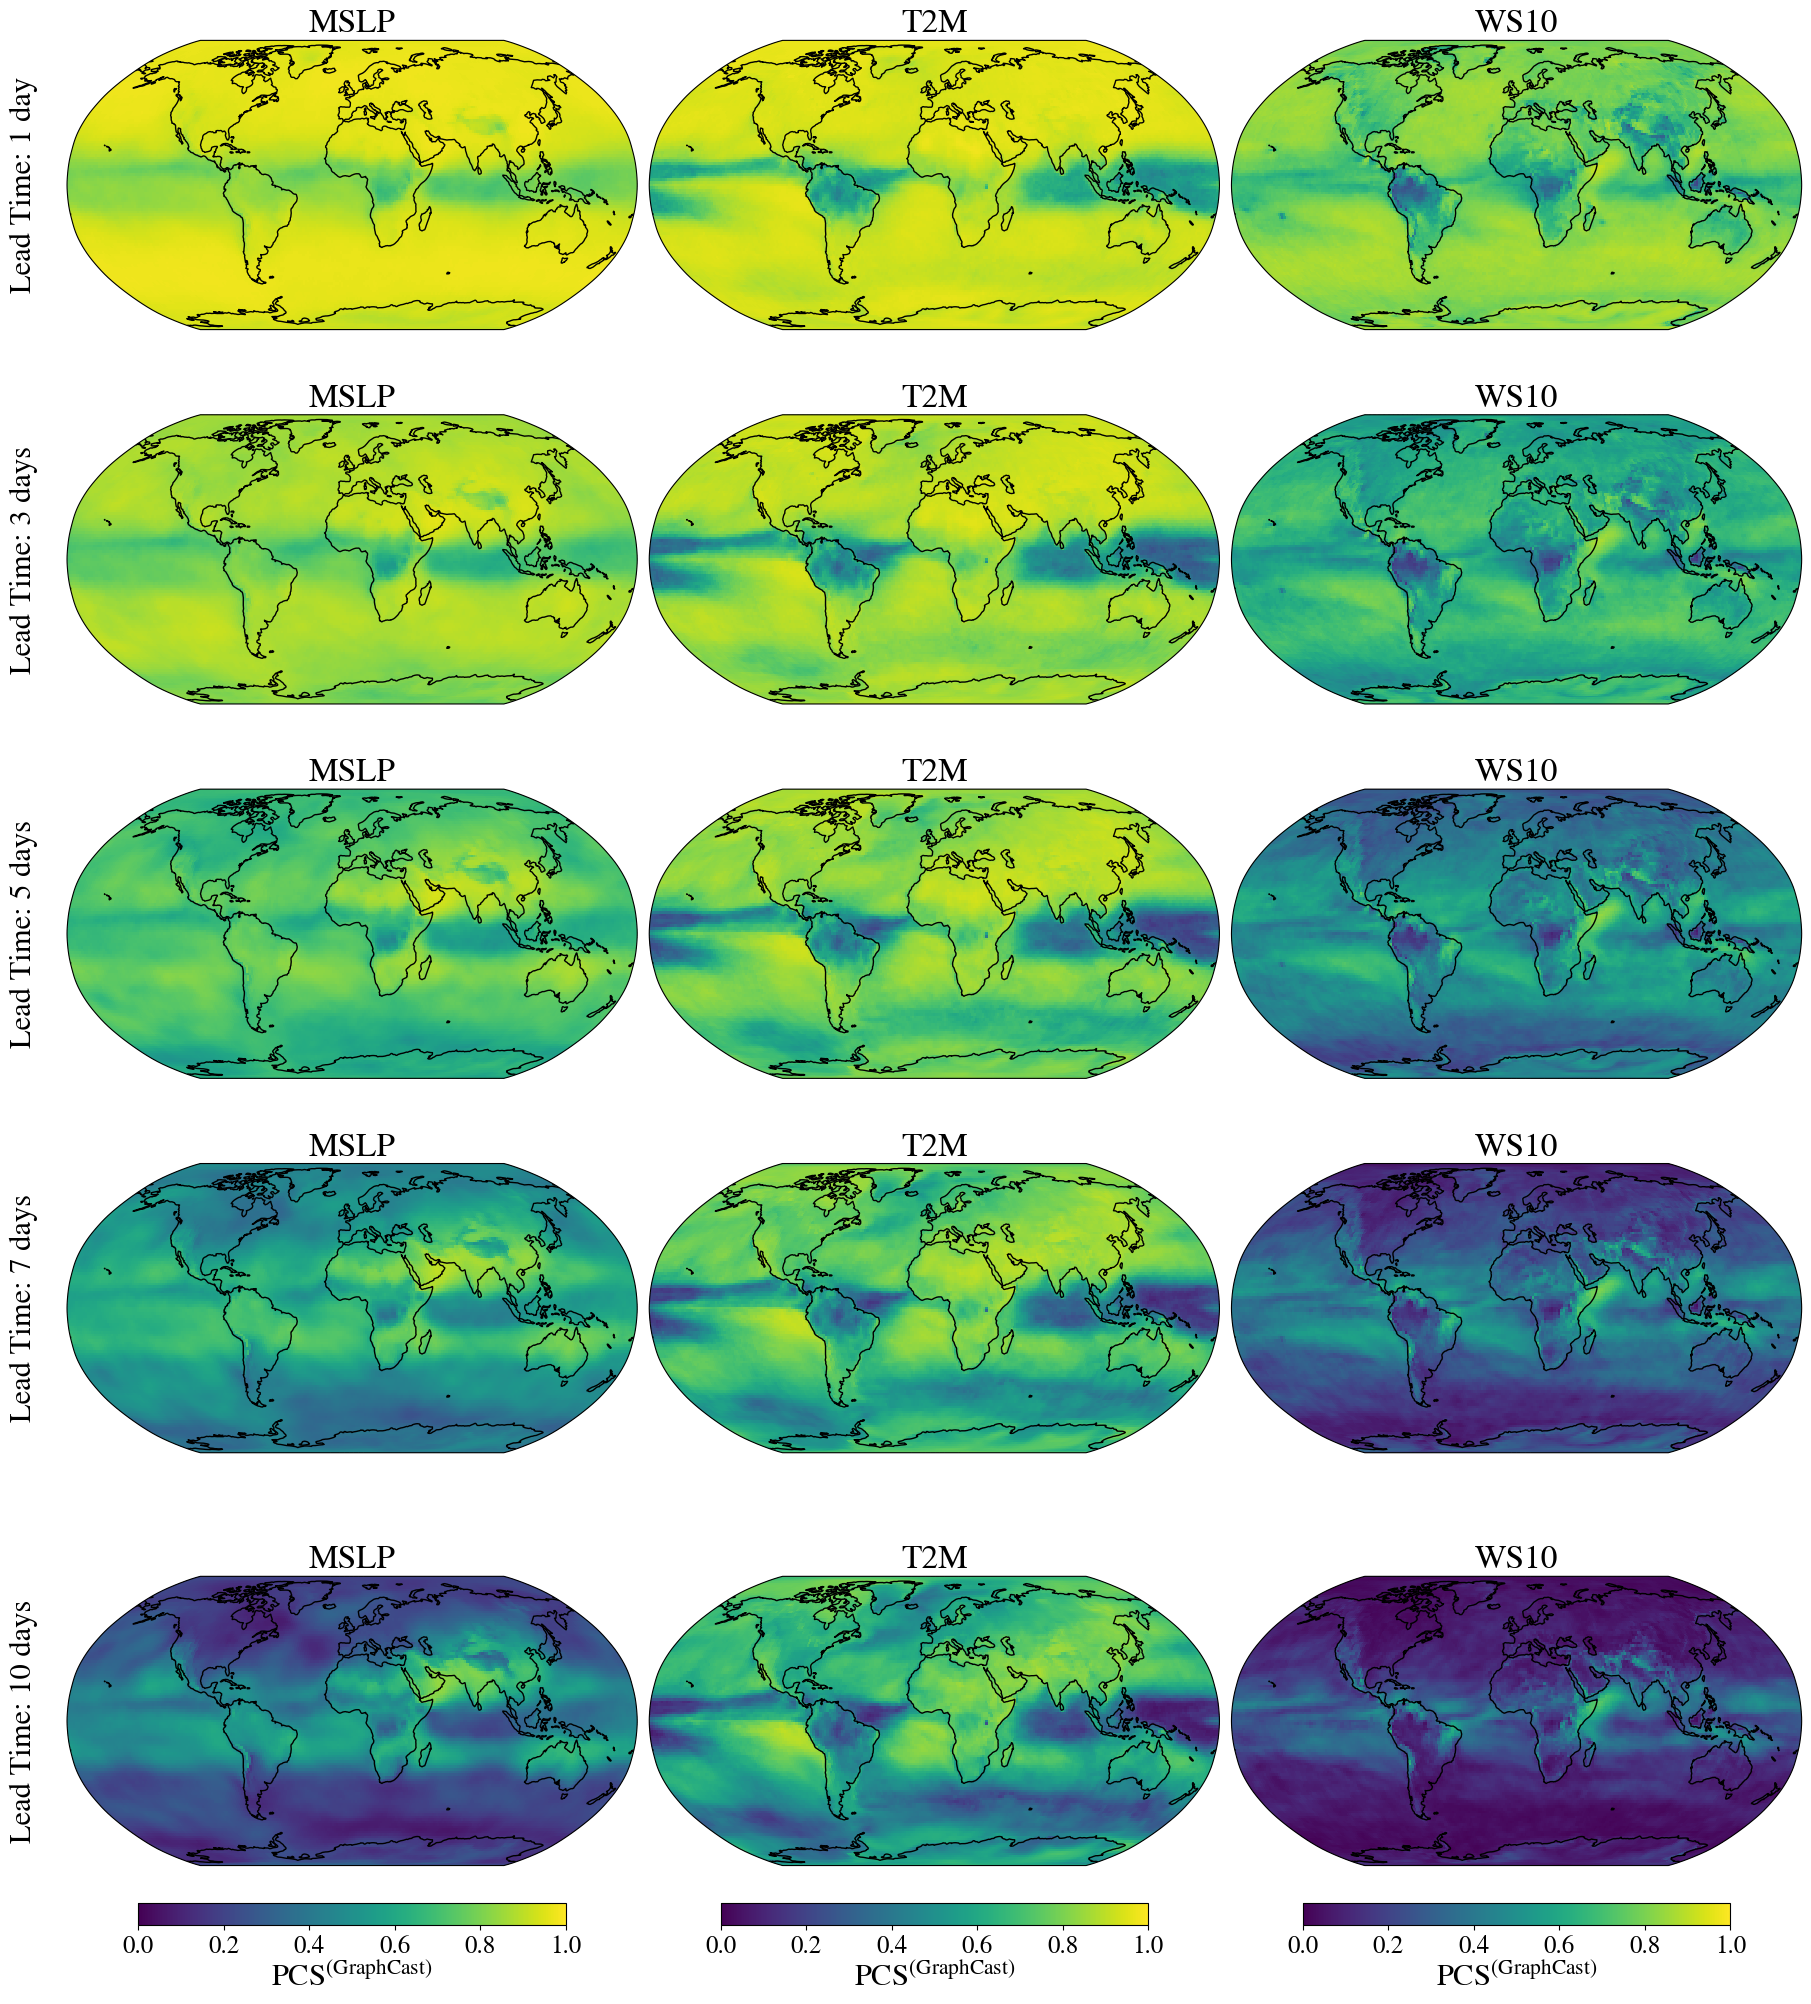

In [41]:
# Create a meshgrid for plotting
lon = era5_pc0['longitude'].values
lat = era5_pc0['latitude'].values
lon_grid, lat_grid = np.meshgrid(lon, lat)

n_rows = len(lead_times)
n_cols = len(variables[:-1])

# Create a grid of subplots with one row per lead time and one column per variable
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 4), subplot_kw={'projection': ccrs.Robinson()}, constrained_layout=True)

for i, lt in enumerate(lead_times):
    # Convert lead time to days for the row label
    lt_days = int(lt / np.timedelta64(1, 'D'))
    
    for j, (var, var_title) in enumerate(zip(variables[:-1], titles[:-1])):
        ax = axes[i, j]
        ax.coastlines()
        
        # Select the data for the variable at the given lead time
        data = graphcast_vs_era5_results.sel(metric='pcs', prediction_timedelta=lt)[var]
        
        # Normalize
        norm = mcolors.Normalize(vmin=0, vmax=1)
        
        # Plot the data
        mesh = ax.pcolormesh(lon_grid, lat_grid, data.T, cmap='viridis', norm=norm, transform=ccrs.PlateCarree(), linewidth=0.5)
        
        # Every subplot gets its variable title on top
        ax.set_title(var_title, fontsize=24)
        
        # If this is the bottom row, add an x-axis label and the colorbar
        if i == n_rows - 1:
            ax.set_xlabel('Longitude')
            cbar = plt.colorbar(mesh, ax=ax, orientation='horizontal', shrink=0.75, pad=0.1)
            cbar.ax.tick_params(labelsize=18)
            cbar.set_label('$\\text{PCS}^{(\\text{GraphCast})}$', fontsize=22)
    
    # Annotate the left-most subplot of the current row with the lead time information.
    axes[i, 0].annotate(
        f"Lead Time: {lt_days} day" if i==0 else f"Lead Time: {lt_days} days",
        fontsize=22,
        xy=(-0.1, 0.5), 
        xycoords='axes fraction',
        rotation=90, 
        va='center'
    )

plt.savefig('plots/maps_graphcast_240x121_vs_era5_pcs_without_precip.png', facecolor='white', edgecolor='none', bbox_inches='tight')

plt.show()

Scatterplot for in-sample PC of IFS HRES vs out-of-sample CRPS of IFS ENS with ERA5 as ground truth.

In [ ]:
# Get CRPS of IFS ENS for each grid point using the official evaluation script from WeatherBench 2
python weatherbench2/scripts/evaluate.py \
--forecast_path=gs://weatherbench2/datasets/ifs_ens/2018-2022-240x121_equiangular_with_poles_conservative.zarr \
--obs_path=gs://weatherbench2/datasets/era5/1959-2023_01_10-6h-240x121_equiangular_with_poles_conservative.zarr \
--climatology_path=gs://weatherbench2/datasets/era5-hourly-climatology/1990-2019_6h_240x121_equiangular_with_poles_conservative.zarr \
--output_dir=gs://$BUCKET/baseline/ \
--output_file_prefix=ifs_ens_240x121_surface_vs_era5_2020_ \
--input_chunks=init_time=1,lead_time=1 \
--eval_configs=probabilistic_spatial \
--variables=2m_temperature,mean_sea_level_pressure,10m_wind_speed,total_precipitation_24hr \
--use_beam=True \
--runner=DataflowRunner \
-- \
--project=$PROJECT \
--region=$REGION \
--job_name=evaluate-ifs-ens-240x121-vs-era5-surface \
--temp_location=gs://$BUCKET/tmp/ \
--setup_file=./wb2_eval_setup.py \
--worker_machine_type=c3-highmem-8 \
--autoscaling_algorithm=THROUGHPUT_BASED

In [31]:
with ProgressBar():
    ifs_ens_vs_era5 = xr.open_zarr('gs://$BUCKET/baseline/ifs_ens_240x121_surface_vs_era5_2020_probabilistic_spatial.zarr').sel(lead_time=lead_times, metric='crps').load()

[########################################] | 100% Completed | 1.82 ss


In [ ]:
ifs_ens_vs_era5.to_netcdf('results/ifs_ens_vs_era5_crps.nc', engine='h5netcdf')

In [43]:
ifs_ens_vs_era5 = xr.open_dataset('results/ifs_ens_vs_era5_crps.nc').load()

In [47]:
ens_crps = ifs_ens_vs_era5.rename(lead_time="prediction_timedelta").transpose(*ifs_hres_vs_era5_results.sel(metric="pc").dims)
hres_pc = ifs_hres_vs_era5_results.sel(metric="pc")

Compute Pearson's $r$ and Spearman's $\rho$ for for each variable overall as well as stratified by lead time.

In [57]:
corr_df = pd.DataFrame(index=variables, columns=['pearson', 'spearman'])

for i, var in enumerate(variables):    
    x = ens_crps[var].values.flatten()
    y = hres_pc[var].values.flatten()
    pearson_val, _ = pearsonr(x, y)
    spearman_val, _ = spearmanr(x, y)
    corr_df.loc[var, 'pearson'] = pearson_val
    corr_df.loc[var, 'spearman'] = spearman_val

In [58]:
corr_df

,pearson,spearman
mean_sea_level_pressure,0.996708,0.991663
2m_temperature,0.952673,0.966303
10m_wind_speed,0.995835,0.994627
total_precipitation_24hr,0.995726,0.99625


In [62]:
pearson_df_lt = pd.DataFrame(index=variables, columns=[int(lt) for lt in lead_time_days])
spearman_df_lt = pd.DataFrame(index=variables, columns=[int(lt) for lt in lead_time_days])

for i, var in enumerate(variables):    
    for j, lt in enumerate(hres_pc.prediction_timedelta):
        x = ens_crps.sel(prediction_timedelta=lt)[var].values.flatten()
        y = hres_pc.sel(prediction_timedelta=lt)[var].values.flatten()
        pearson_val, _ = pearsonr(x, y)
        spearman_val, _ = spearmanr(x, y)
        pearson_df_lt.iloc[i,j] = pearson_val
        spearman_df_lt.iloc[i,j] = spearman_val

In [63]:
pearson_df_lt

,1,3,5,7,10
mean_sea_level_pressure,0.964764,0.99237,0.997476,0.997799,0.996853
2m_temperature,0.928104,0.935061,0.955653,0.974082,0.984577
10m_wind_speed,0.921626,0.987055,0.995347,0.995762,0.994877
total_precipitation_24hr,0.995803,0.996243,0.995436,0.995902,0.997367


In [64]:
spearman_df_lt

,1,3,5,7,10
mean_sea_level_pressure,0.939209,0.99034,0.991967,0.99389,0.994446
2m_temperature,0.959281,0.96026,0.973456,0.981037,0.986573
10m_wind_speed,0.946904,0.987069,0.995232,0.995636,0.994534
total_precipitation_24hr,0.993713,0.99517,0.995589,0.996943,0.998432


Plot the results

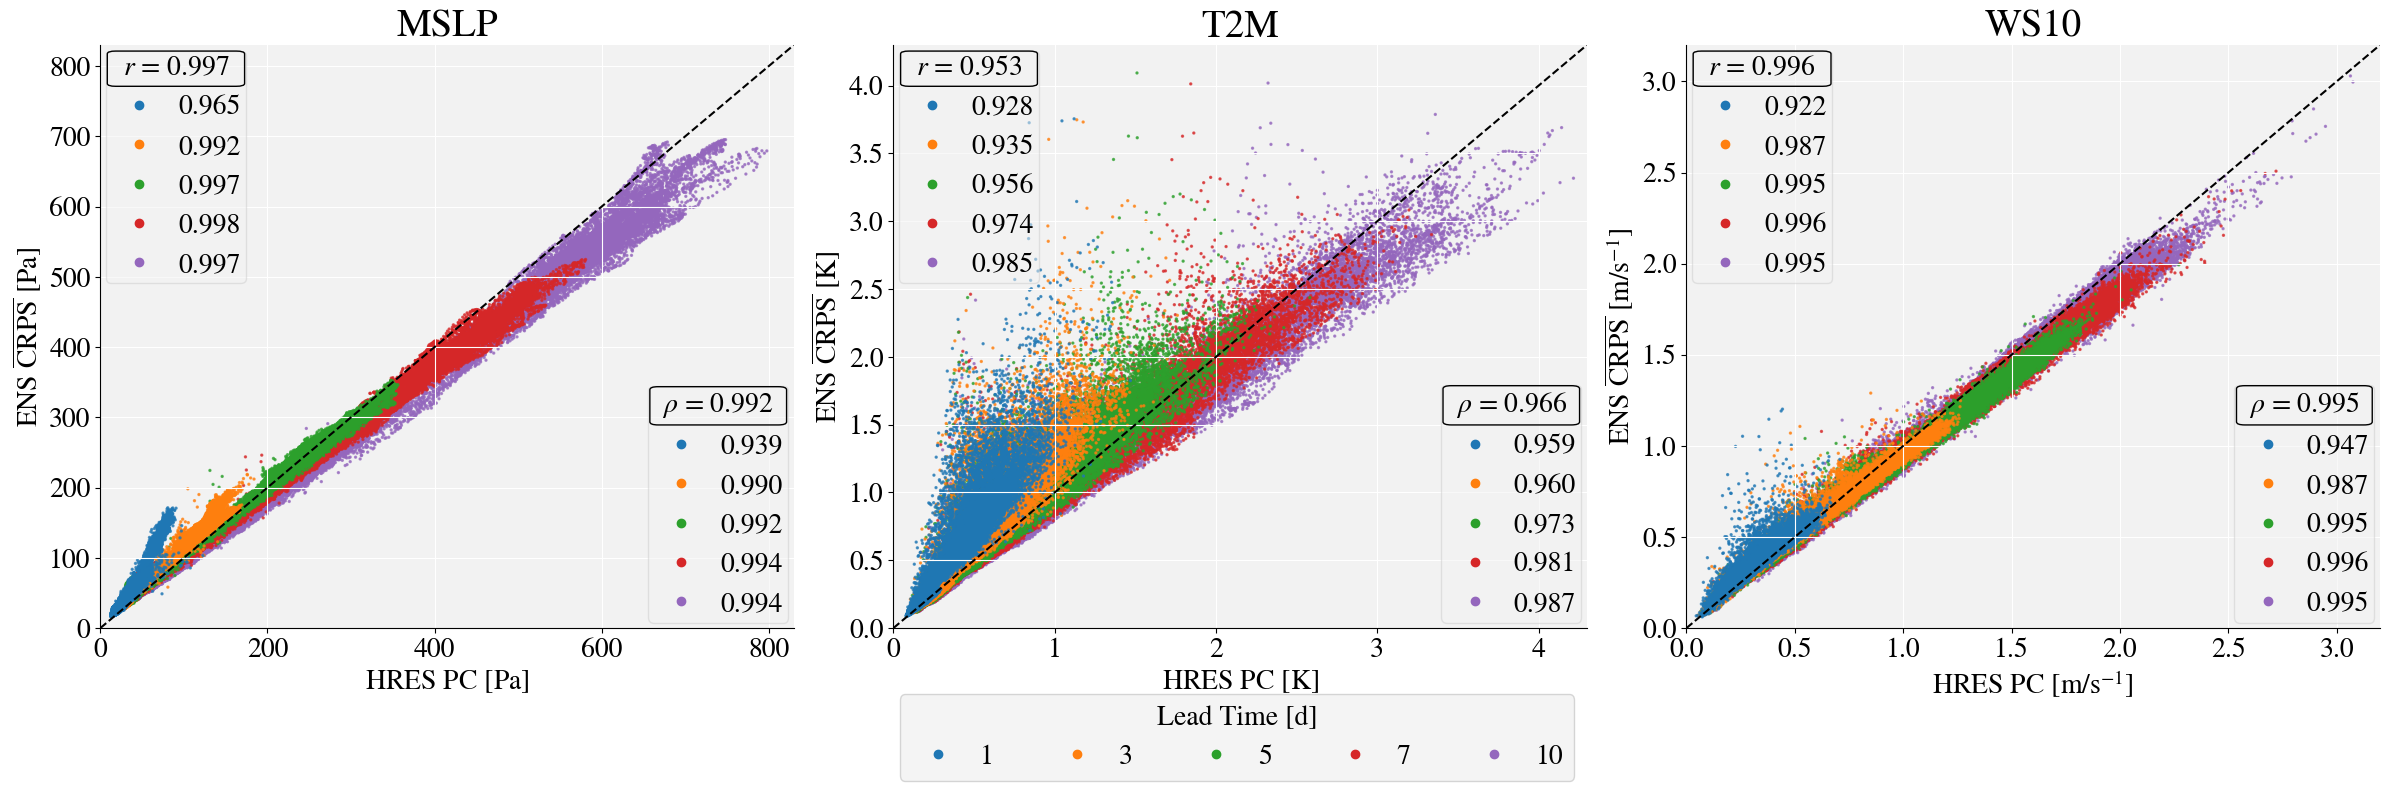

In [92]:
xlims = [(0, 830), (0, 4.3), (0, 3.2)] 
ylims = [(0, 830), (0, 4.3), (0, 3.2)]  

fig, axes = plt.subplots(1, len(variables[:-1]), figsize=(24, 8))

for ax, var, title, xlim_val, ylim_val, unit in zip(axes, variables[:-1], titles[:-1], xlims, ylims, units[:-1]):
    
    # Stack (prediction_timedelta, latitude, longitude) into one dimension "points"
    ens_data_stacked = ifs_ens_vs_era5[var].rename(lead_time="prediction_timedelta").stack(points=("prediction_timedelta", "latitude", "longitude"))
    hres_data_stacked = hres_pc[var].stack(points=("prediction_timedelta", "latitude", "longitude"))
    
    # Align the two DataArrays so that they share matching coordinates
    ens_aligned, hres_aligned = xr.align(ens_data_stacked, hres_data_stacked, join="inner")
    
    # Convert to NumPy arrays
    x = hres_aligned.values
    y = ens_aligned.values
    
    # Extract lead times (in days) from the 'prediction_timedelta' coordinate
    lt_days = ens_aligned["prediction_timedelta"].dt.days.values
    
    # Use discrete, standard colors (one per unique lead time)
    unique_leads = np.unique(lt_days)
    standard_colors = ['C0', 'C1', 'C2', 'C3', 'C4']
    lead_to_color = dict(zip(unique_leads, standard_colors))
    
    # Map the lead time values to the corresponding colors
    point_colors = np.array([lead_to_color[lt] for lt in lt_days])
    
    # Create the scatter plot
    ax.scatter(x[::-1], y[::-1], c=point_colors[::-1], s=2, alpha=0.7)
    
    # Add a reference line from the origin to the top-right corner of the limits
    ax.plot([xlim_val[0], xlim_val[1]], [ylim_val[0], ylim_val[1]], color='k', linestyle='--', linewidth=1.5)
    
    ax.set_ylabel("ENS $\overline{\\text{CRPS}}$ " + unit, fontsize=20)
    ax.set_xlabel("HRES PC " + unit, fontsize=20)
    ax.set_title(title, fontsize=28)
    ax.set_xlim(xlim_val)
    ax.set_ylim(ylim_val)
    ax.tick_params(axis='both', which='major', labelsize=20)

    # Build legend for Pearson's r in UL corner
    pearson_handles = []
    pearson_labels  = []
    for j, lt in enumerate(unique_leads):
        pearson_handles.append(Line2D([], [], color=lead_to_color[lt], marker='o', linestyle='None', markersize=6))
        pearson_labels.append(f"{pearson_df_lt.loc[var,lt]:.3f}")

    pearson_full = corr_df.loc[var, 'pearson']
    leg1 = ax.legend(
        pearson_handles, pearson_labels,
        title=f"$r$ = {pearson_full:.3f}",
        loc="upper left",
        fontsize=20, title_fontsize=20,
        framealpha=0.5,
        borderpad=0.2,
        borderaxespad=0.2,
        handletextpad=0.4
    )
    # Box the overall r
    title1 = leg1.get_title()
    title1.set_bbox(
        dict(
            mutation_aspect=0.33,
            fill=False,
            edgecolor='black',
            boxstyle='round,pad=0.55,rounding_size=0.3'
        )
    )
    ax.add_artist(leg1)

    # Build legend for Spearman's ρ in LR corner
    spearman_handles = []
    spearman_labels  = []
    for j, lt in enumerate(unique_leads):
        spearman_handles.append(Line2D([], [], color=lead_to_color[lt], marker='o', linestyle='None', markersize=6))
        spearman_labels.append(f"{spearman_df_lt.loc[var,lt]:.3f}")
        
    spearman_full = corr_df.loc[var, 'spearman']
    leg2 = ax.legend(
        spearman_handles, spearman_labels,
        title=f"$\\rho$ = {spearman_full:.3f}",
        loc="lower right",
        fontsize=20, title_fontsize=20,
        framealpha=0.5,
        borderpad=0.2,
        borderaxespad=0.2,
        handletextpad=0.4
    )
    # Box the overall ρ
    title2 = leg2.get_title()
    title2.set_bbox(
        dict(
            mutation_aspect=0.37,
            fill=False,
            edgecolor='black',
            boxstyle='round,pad=0.45,rounding_size=0.3'
        )
    )

# Create combined legend
legend_handles = []
for lt in unique_leads:
    color = lead_to_color[lt]
    handle = Line2D([], [], color=color, marker='o', linestyle='None', markersize=6, label=int(lt))
    legend_handles.append(handle)

# Add the legend at the bottom center of the figure.
fig.legend(
    legend_handles, 
    [handle.get_label() for handle in legend_handles],
    loc='lower center', 
    ncol=len(unique_leads), 
    bbox_to_anchor=(0.5175, 0.0), 
    fontsize=18, 
    title='Lead Time [d]', 
    title_fontsize=20, 
    prop={'size': 20}, 
    handletextpad=0.5
)

plt.tight_layout(rect=[0, 0.1, 1, 1])

plt.savefig('plots/scatterplot_ens_vs_hres.png', facecolor='white', edgecolor='none', bbox_inches='tight')
plt.show()